In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
import matplotlib.pyplot as plt

In [11]:
# Load the data
data = pd.read_csv('../../../dane/8CPU_20RAM/3600s/2repl/merged.csv')

In [12]:
# Convert 'api_endpoint' categorical data into numerical data
le = LabelEncoder()
data['endpointUrl_methods'] = le.fit_transform(data['endpointUrl_methods'])

In [13]:
# Normalize 'timestamp' and 'api_endpoint' to range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data[['timestamp', 'endpointUrl_methods']] = scaler.fit_transform(data[['timestamp', 'endpointUrl_methods']])

In [14]:
# Choose sequence length and step size
sequence_length = 10000
step_size = 500

In [15]:
# Create sequences with a step size of 10
X = np.array([data[['timestamp', 'endpointUrl_methods']].values[i: i + sequence_length] for i in range(0, len(data) - sequence_length, step_size)])
y = data['cpuUsage_stock'].values[sequence_length::step_size]

In [16]:
# Suppose that the 80% of data is the training set
train_size = int(len(data) * 0.8)

# Split the data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [17]:
# Create LSTM model
model = Sequential()
model.add(GRU(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(5, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [18]:
# Fit model
model.fit(X_train, y_train, epochs=4, batch_size=72, validation_data=(X_train, y_train), shuffle=False)

Epoch 1/4
15/15 [==============================] - 130s 9s/step - loss: 0.3259 - val_loss: 0.2241
Epoch 2/4
15/15 [==============================] - 130s 9s/step - loss: 0.1601 - val_loss: 0.1123
Epoch 3/4
15/15 [==============================] - 122s 8s/step - loss: 0.1082 - val_loss: 0.0943
Epoch 4/4
15/15 [==============================] - 128s 9s/step - loss: 0.0984 - val_loss: 0.0890


In [19]:
yhat = model.predict(X_train)

33/33 [==============================] - 26s 758ms/step


In [20]:
df = pd.DataFrame({'Actual': y_train.flatten(), 'Predicted': yhat.flatten()})

In [21]:
df.index = np.arange(sequence_length + train_size, sequence_length + train_size + len(y_train)*step_size, step_size)

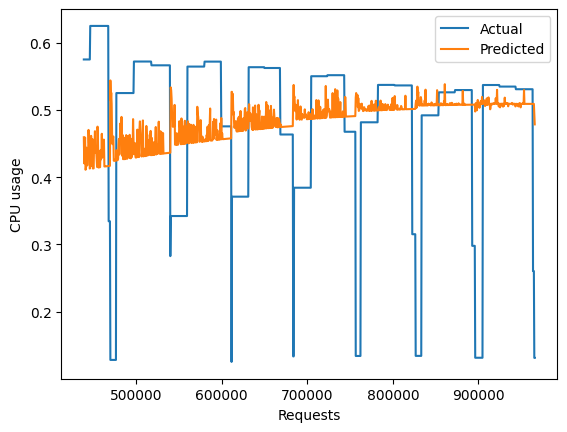

In [22]:
df.plot(kind='line', y=['Actual', 'Predicted'])
plt.xlabel('Requests') 
plt.ylabel('CPU usage')  
plt.show()